In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import pandas as pd
import seaborn as sns

# Load data, sum across all chromosomes
dfs = []
sizecols = list(range(-11, 12))
for chrom in range(1, 11): # TODO put back
    data = pd.read_csv("asize_summary_chr%s.tab"%chrom, sep="\t", 
                  names=["sample","spop","pop","type"] + sizecols)
    data
    dfs.append(data)
data = pd.concat(dfs)
aggdict = {}
for i in sizecols: aggdict[i] = np.sum
data = data.groupby(["sample","spop","pop","type"], as_index=False).agg(aggdict).sort_values(["spop","pop"])

Populating the interactive namespace from numpy and matplotlib


In [2]:
def GetRowColors(spop):
    if "EUR" in spop: return "blue"
    if "AFR" in spop: return "gold"
    if "AMR" in spop: return "red"
    if "EAS" in spop: return "green"
    if "SAS" in spop: return "purple"
    if "H3" in spop: return "gray"

# Histograms of diff from ref

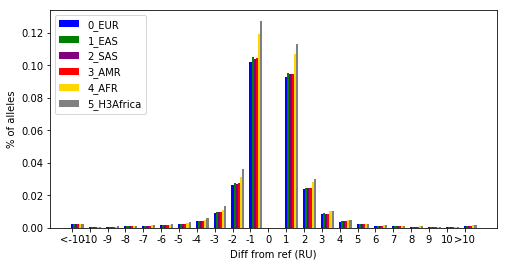

In [3]:
bypop = data[data["type"]=="hom"].groupby("spop").agg(aggdict)
bypop = bypop.div(bypop.sum(axis=1), axis=0)
bypop[0] = np.nan

w = 0.12
fig = plt.figure()
fig.set_size_inches((8, 4))
ax = fig.add_subplot(111)
i = 0
for pop in sorted(list(bypop.index)):
    vals = bypop.loc[pop]
    color = GetRowColors(pop)
    ax.bar([item+w*i for item in sizecols], vals, color=color, label=pop, width=w)
    i += 1
ax.legend(loc="upper left")
ax.set_xticks(sizecols)
ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
ax.set_xlabel("Diff from ref (RU)")
ax.set_ylabel("% of alleles")
fig.savefig("diff-from-ref-homopolymer.pdf")

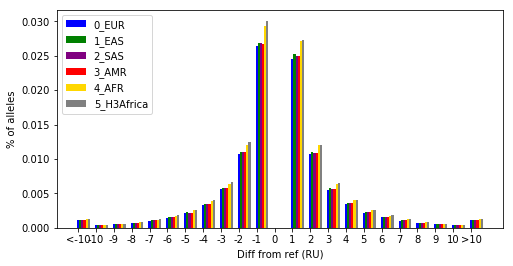

In [4]:
bypop = data[data["type"]=="other"].groupby("spop").agg(aggdict)
bypop = bypop.div(bypop.sum(axis=1), axis=0)
bypop[0] = np.nan

w = 0.12
fig = plt.figure()
fig.set_size_inches((8, 4))
ax = fig.add_subplot(111)
i = 0
for pop in sorted(list(bypop.index)):
    vals = bypop.loc[pop]
    color = GetRowColors(pop)
    ax.bar([item+w*i for item in sizecols], vals, color=color, label=pop, width=w)
    i += 1
ax.legend(loc="upper left")
ax.set_xticks(sizecols)
ax.set_xticklabels(["<-10"]+list(range(-10, 11)) + [">10"])
ax.set_xlabel("Diff from ref (RU)")
ax.set_ylabel("% of alleles")
fig.savefig("diff-from-ref-other.pdf")

# Diff vs. allele freq

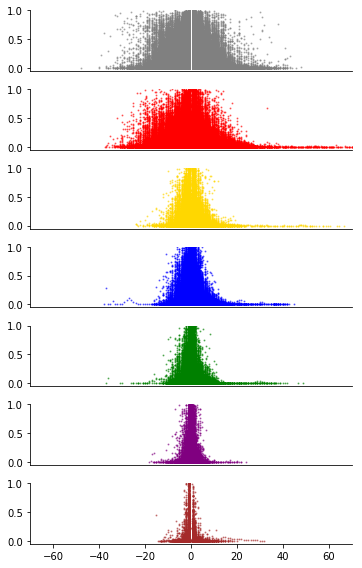

In [5]:
diffs = pd.read_csv("diff_afreqs.tab", sep="\t", names=["chrom","start","period","diff","freq"])

percolors = {
    1: "gray",
    2: "red",
    3: "gold",
    4: "blue",
    5: "green",
    6: "purple",
    7: "brown"
}
fig = plt.figure()
fig.set_size_inches((5, 8))
for period in range(1, 8):
    if period <= 6:
        xx = diffs[(diffs["period"]==period) & (diffs["diff"].apply(abs) >= 0)]
    else:
        xx = diffs[(diffs["period"]>=period) & (diffs["diff"].apply(abs) >= 0)]
    ax = fig.add_subplot(7, 1, period)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.scatter(xx["diff"], xx["freq"], color=percolors[period], s=1, alpha=0.5)
    ax.set_xlim(left=-70, right=70)
    ax.set_ylim(bottom=-0.05, top=1)
    if period != 7: ax.set_xticks([])
fig.tight_layout()
fig.savefig("adiffs-byperiod.png")

# Investigate places where almost everyone is very different from ref

Can validate by looking at pacbio reads? or visualizing alignments somehow?

Example: chr17:67242510 everyone has -20
chr12:115076223, everyone has +14
see it in pacbio for HG00438
https://s3-us-west-2.amazonaws.com/human-pangenomics/index.html?prefix=working/HPRC/HG00438/analysis/aligned_reads/hifi/GRCh38/
can load to IGV

In [18]:
# how often does this happen?
for thresh in [2, 5, 10]:
    print(diffs[(diffs["freq"]>0.95) & (diffs["diff"].apply(abs)>thresh)].shape[0])

196
66
20


In [12]:
diffs[(diffs["freq"]>0.95) & (diffs["period"]==3)].sort_values("diff")

,chrom,start,period,diff,freq
3429583,chr16,81766466,3,-6.00,0.985
3090540,chr14,47675310,3,-5.00,0.988
946023,chr3,188469343,3,-3.00,1.000
2151393,chr8,144351885,3,-2.00,0.978
2560605,chr11,31702306,3,-2.00,0.977
...,...,...,...,...,...
2912504,chr12,131828553,3,3.00,0.964
2901185,chr12,124340175,3,3.00,0.971
2812069,chr12,72672486,3,3.00,0.963
3378727,chr16,53131065,3,6.67,0.977


# Common polymorphic expansions

Like chr1:77,886,216-77,889,607 NEXN chr1:77887912
see it in pacbio for HG00438
https://s3-us-west-2.amazonaws.com/human-pangenomics/index.html?prefix=working/HPRC/HG00438/analysis/aligned_reads/hifi/GRCh38/
can load to IGV

also chr11:126065034 (VNTR)

In [20]:
diffs[(diffs["period"]>6) & (diffs["freq"]>0.001)].sort_values("diff", ascending=False).head(n=50)

,chrom,start,period,diff,freq
2691447,chr11,126065034,16,32.00,0.002
2691446,chr11,126065034,16,31.00,0.004
2691445,chr11,126065034,16,30.00,0.006
2691444,chr11,126065034,16,29.00,0.009
2691443,chr11,126065034,16,28.00,0.010
2691442,chr11,126065034,16,27.00,0.015
2691441,chr11,126065034,16,26.00,0.016
2691440,chr11,126065034,16,25.00,0.019
2691439,chr11,126065034,16,24.00,0.023
2691438,chr11,126065034,16,23.00,0.023


In [8]:
diffs[(diffs["period"]>6) & (diffs["freq"]>0.01)].sort_values("diff", ascending=False).head(n=50)

,chrom,start,period,diff,freq
2691442,chr11,126065034,16,27.00,0.015
2691441,chr11,126065034,16,26.00,0.016
2691440,chr11,126065034,16,25.00,0.019
2691439,chr11,126065034,16,24.00,0.023
2691438,chr11,126065034,16,23.00,0.023
2691437,chr11,126065034,16,22.00,0.028
2691436,chr11,126065034,16,21.00,0.031
2691435,chr11,126065034,16,20.00,0.034
2691434,chr11,126065034,16,19.00,0.035
2691433,chr11,126065034,16,18.00,0.039
